In [ ]:
# %tensorflow_version 1.x
#we need imgaug 0.4 for image augmentations to work properly, see https://stackoverflow.com/questions/62580797/in-colab-doing-image-data-augmentation-with-imgaug-is-not-working-as-intended
!pip install --upgrade gdown
!pip uninstall -y imgaug && pip uninstall -y albumentations && pip install Keras-Applications && pip install Keras-Preprocessing
!git clone --branch dev https://github.com/apinuntong/aXeleRate-legacy-yolov2.git
!pip install git+https://github.com/duonglong289/imgaug.git
import sys
sys.path.append('/content/aXeleRate-legacy-yolov2')
from axelerate import setup_training,setup_inference

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0
Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
Found existing installation: albumentations 1.3.1
Uninstalling albumentations-1.3.1:
  Successfully uninstalled albumentations-1.3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
Cloning into 'aXeleRate-legacy-yolov2'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 530 (delta 132), reused 12 (delta 12), pack-reused 329
Receiving objects: 100% (530/530), 1.94 MiB | 15.51 MiB/s, done.
Resolving deltas: 100% (236/236), done.
  Cloning https://github.com/duonglong289/imgaug.git to /tmp/pip-req-build-9ieecije
  Running c

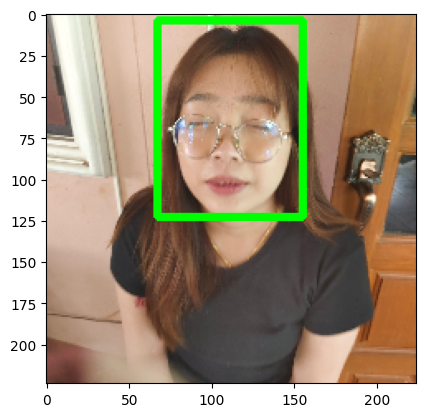

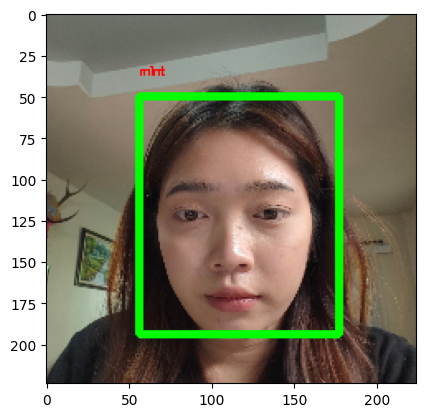

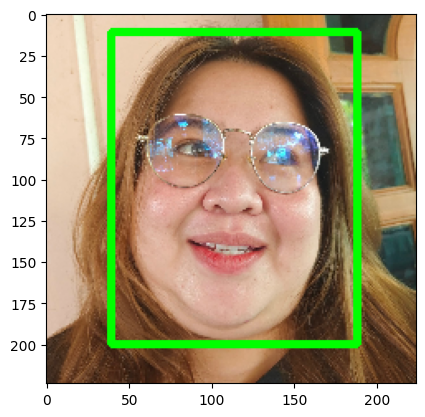

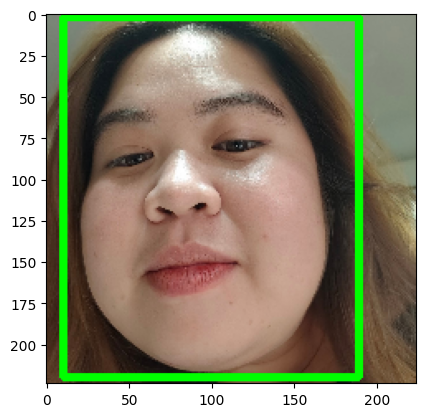

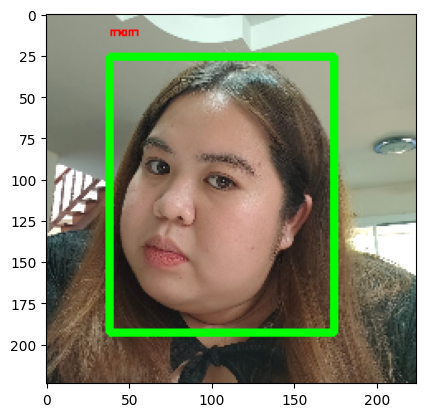

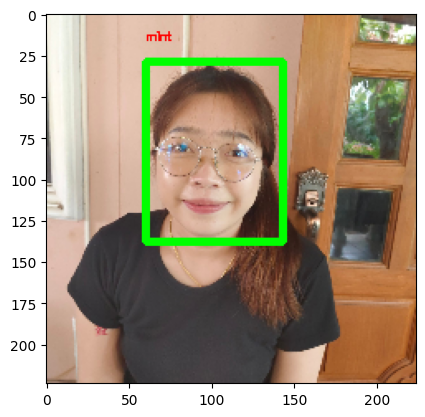

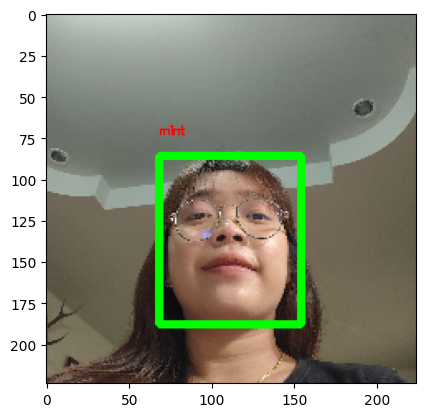

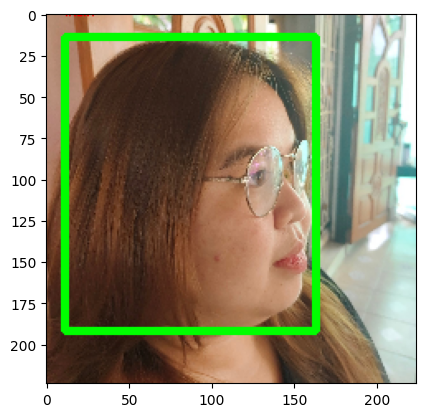

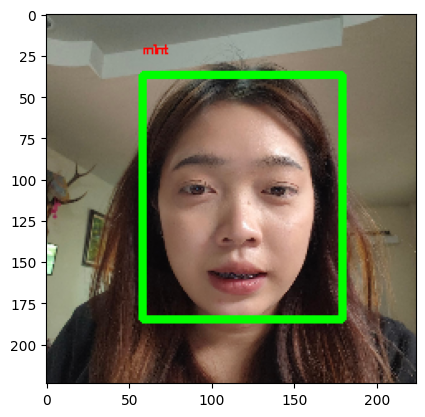

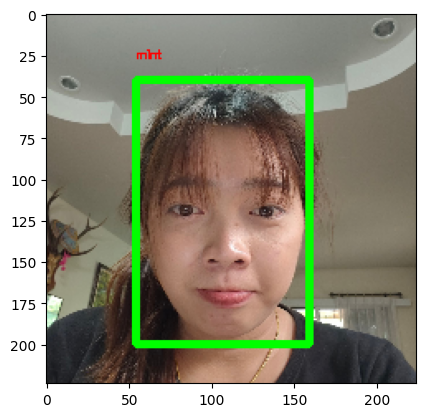

In [ ]:
%matplotlib inline
# !gdown https://drive.google.com/file/d/1q4tjVdfCGr5eFSJ-iF5D0-b0td3peend/view?usp=sharing  #pascal-voc dataset
!unzip --qq Traffic.zip


from axelerate.networks.common_utils.augment import visualize_detection_dataset

visualize_detection_dataset(img_folder='/content/JPEGImages/', ann_folder='/content/Annotations/', num_imgs=10, img_size=224)

In [ ]:
import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)



In [ ]:
createFolder('/content/annotations_v/')
createFolder('/content/images_v/')

In [ ]:
import os, random, shutil
files = os.listdir("/content/JPEGImages/")
random.shuffle(files)
files = files[0:45]
for file in files:
    imgSrc = "/content/JPEGImages/" + file
    imgTarget = "/content/images_v/" + file
    annoSrc = "/content/Annotations/" + os.path.splitext(file)[0] + ".xml"
    annoTarget = "/content/annotations_v/" + os.path.splitext(file)[0] + ".xml"
    shutil.move(imgSrc,imgTarget)
    shutil.move(annoSrc,annoTarget)

In [ ]:
import xml.etree.ElementTree as ET
import os
import numpy as np
import random
def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}
        tree = ET.parse(ann_dir + ann)
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1

                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))
        if len(img['object']) > 0:
            all_imgs += [img]
    return all_imgs, seen_labels

def IOU(ann, centroids):
    w, h = ann
    similarities = []

    for centroid in centroids:
        c_w, c_h = centroid

        if c_w >= w and c_h >= h:
            similarity = w*h/(c_w*c_h)
        elif c_w >= w and c_h <= h:
            similarity = w*c_h/(w*h + (c_w-w)*c_h)
        elif c_w <= w and c_h >= h:
            similarity = c_w*h/(w*h + c_w*(c_h-h))
        else: #means both w,h are bigger than c_w and c_h respectively
            similarity = (c_w*c_h)/(w*h)
        similarities.append(similarity) # will become (k,) shape

    return np.array(similarities)

def avg_IOU(anns, centroids):
    n,d = anns.shape
    sum = 0.

    for i in range(anns.shape[0]):
        sum+= max(IOU(anns[i], centroids))

    return sum/n

def print_anchors(centroids):
    anchors = centroids.copy()

    widths = anchors[:, 0]
    sorted_indices = np.argsort(widths)

    r = "anchors: ["
    for i in sorted_indices[:-1]:
        r += '%0.4f,%0.2f, ' % (anchors[i,0], anchors[i,1])

    #there should not be comma after last anchor, that's why
    r += '%0.4f,%0.4f' % (anchors[sorted_indices[-1:],0], anchors[sorted_indices[-1:],1])
    r += "]"

    print(r)

def run_kmeans(ann_dims, anchor_num):
    ann_num = ann_dims.shape[0]
    iterations = 0
    prev_assignments = np.ones(ann_num)*(-1)
    iteration = 0
    old_distances = np.zeros((ann_num, anchor_num))

    indices = [random.randrange(ann_dims.shape[0]) for i in range(anchor_num)]
    centroids = ann_dims[indices]
    anchor_dim = ann_dims.shape[1]

    while True:
        distances = []
        iteration += 1
        for i in range(ann_num):
            d = 1 - IOU(ann_dims[i], centroids)
            distances.append(d)
        distances = np.array(distances) # distances.shape = (ann_num, anchor_num)

        print("iteration {}: dists = {}".format(iteration, np.sum(np.abs(old_distances-distances))))

        #assign samples to centroids
        assignments = np.argmin(distances,axis=1)

        if (assignments == prev_assignments).all() :
            return centroids

        #calculate new centroids
        centroid_sums=np.zeros((anchor_num, anchor_dim), np.float32)
        for i in range(ann_num):
            centroid_sums[assignments[i]]+=ann_dims[i]
        for j in range(anchor_num):
            centroids[j] = centroid_sums[j]/(np.sum(assignments==j) + 1e-6)

        prev_assignments = assignments.copy()
        old_distances = distances.copy()

def gen_anchor(anno_path,image_path,num_anchors,labels,input_size):
    train_imgs, train_labels = parse_annotation(anno_path,image_path,labels)

    grid_w = input_size[0]/32
    grid_h = input_size[1]/32

    # run k_mean to find the anchors
    annotation_dims = []
    for image in train_imgs:
        cell_w = image['width']/grid_w
        cell_h = image['height']/grid_h

        for obj in image['object']:
            relative_w = (float(obj['xmax']) - float(obj['xmin']))/cell_w
            relatice_h = (float(obj["ymax"]) - float(obj['ymin']))/cell_h
            annotation_dims.append(tuple(map(float, (relative_w,relatice_h))))

    annotation_dims = np.array(annotation_dims)
    centroids = run_kmeans(annotation_dims, num_anchors)

    # write anchors to file
    print('\naverage IOU for', num_anchors, 'anchors:', '%0.2f' % avg_IOU(annotation_dims, centroids))
    print_anchors(centroids)

In [ ]:

labels = ["mint","mam"]
input_size = [224,224]
gen_anchor("/content/Annotations/","/content/JPEGImages/",5,labels,input_size)

iteration 1: dists = 344.12420727992554
iteration 2: dists = 41.647877976056634
iteration 3: dists = 6.967033540276944
iteration 4: dists = 11.614499155013199
iteration 5: dists = 8.195517564589867
iteration 6: dists = 1.4085079116669252
iteration 7: dists = 0.8869604225428473

average IOU for 5 anchors: 0.89
anchors: [2.4654,3.08, 3.3219,3.86, 3.7231,4.66, 4.2004,5.40, 4.9471,6.0257]


<ipython-input-6-e98a6a1921a3>:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r += '%0.4f,%0.4f' % (anchors[sorted_indices[-1:],0], anchors[sorted_indices[-1:],1])


In [ ]:
config = {
        "model":{
            "type":                 "Detector",
            "architecture":         "MobileNet7_5",
            "input_size":           (224,224),
            "anchors":              [2.4654,3.08, 3.3219,3.86, 3.7231,4.66, 4.2004,5.40, 4.9471,6.0257],
            "labels":               ["mint","mam"],
            "coord_scale" : 		1.0,
            "class_scale" : 		1.0,
            "object_scale" : 		5.0,
            "no_object_scale" : 	1.0
        },
        "weights" : {
            "full":   				"",
            "backend":   		    "imagenet"
        },
        "train" : {
            "actual_epoch":         30,
            "train_image_folder":   "/content/JPEGImages/",
            "train_annot_folder":   "/content/Annotations/",
            "train_times":          5,
            "valid_image_folder":   "/content/images_v/",
            "valid_annot_folder":   "/content/annotations_v/",
            "valid_times":          1,
            "valid_metric":         "mAP",
            "batch_size":           8,
            "learning_rate":        1e-4,
            "saved_folder":   		F"/content/M",
            "first_trainable_layer": "",#เทรนใหม่ทั้งหมด ถ้าเป็น "first_trainable_layer": "dense_1", # ชั้นก่อนหน้าชื่อนี้จะไม่ถูกเทรน (ใช้สำหรับ Transfer Learning)
            "augumentation":				True,
            "is_only_detect" : 		False
        },
        "converter" : {
            "type":   				["k210","tflite"]
        }
    }

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13944017488779336966
 xla_global_id: -1]

In [ ]:
from keras import backend as K
K.clear_session()
model_path = setup_training(config_dict=config)

Project folder /content/M is created.
Tflite Converter ready
7513544/7513544 [==============================] - 0s 0us/step
/content/aXeleRate-legacy-yolov2/axelerate/networks/common_utils/ncc_linux_x86_64.tar.xz


Downloading...
From: https://drive.google.com/uc?id=1bHC6hmbBU4HrMQsxepJv1j8rsO6CxmHq
To: /content/aXeleRate-legacy-yolov2/axelerate/networks/common_utils/corgimodel_tool
100%|██████████| 714k/714k [00:00<00:00, 97.9MB/s]


['mint', 'mam']
10626956/10626956 [==============================] - 0s 0us/step
Successfully loaded imagenet backend weights
Failed to load pre-trained weights for the whole model. It might be because you didn't specify any or the weight file cannot be found


Current training session folder is /content/M/2024-06-20_10-46-29


Model: "yolo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 226, 226, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 24)      648       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 24)      96        
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 24)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 24)      216  

/content/aXeleRate-legacy-yolov2/axelerate/networks/common_utils/fit.py:120: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = train_batch_gen,
/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:188: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/30
1/1 [==============================] - 0s 49ms/step


mint 0.0000
mam 0.0000
mAP: 0.0000
Saving model on first epoch irrespective of mAP
Epoch 00000: Learning rate is 3.3062330623306235e-05.

123/123 [==============================] - 184s 1s/step - loss: 1.0535 - val_loss: 0.9456
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 45ms/step


mint 0.0000
mam 0.0000
mAP: 0.0000
mAP did not improve from 0.
Epoch 00001: Learning rate is 6.639566395663958e-05.

123/123 [==============================] - 164s 1s/step - loss: 0.8238 - val_loss: 0.7077
Epoch 3/30
1/1 [==============================] - 0s 43ms/step


mint 0.0000
mam 0.0000
mAP: 0.0000
mAP did not improve from 0.
Epoch 00002: Learning rate is 9.972899728997291e-05.

123/123 [==============================] - 162s 1s/step - loss: 0.6401 - val_loss: 0.5375
Epoch 4/30
1/1 [==============================] - 0s 44ms/step


mint 0.0000
mam 0.0000
mAP: 0.0000
mAP did not improve from 0.
Epoch 00003: Learning rate is 9.966738673233377e-05.

123/123 [==============================] - 162s 1s/step - loss: 0.4569 - val_loss: 0.3656
Epoch 5/30
1/1 [==============================] - 0s 47ms/step


mint 0.0000
mam 0.0000
mAP: 0.0000
mAP did not improve from 0.
Epoch 00004: Learning rate is 9.866312963456801e-05.

123/123 [====

/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/backend.py:427: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Converting to tflite without Reshape
/content/M/2024-06-20_10-46-29/YOLO_best_mAP.kmodel
/content/aXeleRate-legacy-yolov2/axelerate/networks/common_utils/ncc/ncc compile "/content/M/2024-06-20_10-46-29/YOLO_best_mAP.tflite" "/content/M/2024-06-20_10-46-29/YOLO_best_mAP.kmodel" -i tflite --weights-quantize-threshold 1000 --dataset-format raw --dataset "/content/aXeleRate-legacy-yolov2/axelerate/networks/common_utils/tmp"
1. Import graph...

2. Optimize Pass 1...

3. Optimize Pass 2...

4. Quantize...

  4.1. Add quantization checkpoints...

  4.2. Get activation ranges...

  Plan buffers...

  Run calibration...

  [>                                                 ] 0% 0s

  [=>                                                ] 2% 0.992s

  [==>                                               ] 4% 1.816s

  [===>                                              ] 6% 2.631s

  [====>                                             ] 8% 3.448s

  [=====>                                            ]

In [ ]:
%matplotlib inline
from keras import backend as K
K.clear_session()
setup_inference(config, model_path)

In [ ]:
!zip -r file.zip /content/M/2024-06-20_10-46-29

  adding: content/M/2024-06-20_10-46-29/ (stored 0%)
  adding: content/M/2024-06-20_10-46-29/YOLO_best_mAP.kmodel (deflated 15%)
  adding: content/M/2024-06-20_10-46-29/YOLO_best_mAP.tflite (deflated 7%)
  adding: content/M/2024-06-20_10-46-29/YOLO_best_mAP.h5 (deflated 10%)
  adding: content/M/2024-06-20_10-46-29/Inference_results/ (stored 0%)
  adding: content/M/2024-06-20_10-46-29/Inference_results/074.jpg (deflated 3%)
  adding: content/M/2024-06-20_10-46-29/Inference_results/056.jpg (deflated 3%)
  adding: content/M/2024-06-20_10-46-29/Inference_results/0116.jpg (deflated 3%)
  adding: content/M/2024-06-20_10-46-29/Inference_results/0174.jpg (deflated 3%)
  adding: content/M/2024-06-20_10-46-29/Inference_results/058.jpg (deflated 3%)
  adding: content/M/2024-06-20_10-46-29/Inference_results/017.jpg (deflated 3%)
  adding: content/M/2024-06-20_10-46-29/Inference_results/073.jpg (deflated 3%)
  adding: content/M/2024-06-20_10-46-29/Inference_results/048.jpg (deflated 2%)
  adding: c